In [1]:
import math
from itertools import product
sc.uninstall_package('pip')
sc.install_pypi_package("pip==22.2.2")
sc.install_pypi_package("opencv-python") #Install opencv-python 
sc.install_pypi_package("numpy")
sc.install_pypi_package("matplotlib")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
3,application_1695023391795_0004,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Uninstalling pip-9.0.1:
  Successfully uninstalled pip-9.0.1

  Using cached pip-22.2.2-py3-none-any.whl (2.0 MB)

  Using cached opencv_python-4.8.0.76-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.7 MB)


  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.5-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
  Using cached Pillow-9.5.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)




[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: /tmp/1695024560599-0/bin/python -m pip install --

In [2]:
def cordToTileIndex(latitude, longitude, zoom):
    '''
        Transform geographical coordinates to tile index for a particular zoom level.
    '''
    lat_in_rad = math.radians(latitude)
    tileX = int((longitude + 180.0) / 360.0 * (2.0 ** zoom))
    tileY = int((1.0 - math.asinh(math.tan(lat_in_rad)) / math.pi) / 2.0 * (2.0 ** zoom))
    return (tileX, tileY)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
def getData(zoom_level, latitude1, longitude1, latitude2, longitude2):
    ''' 
        Transform geographic bounds into a list of URLs for tile retrieval at a specified zoom level.
    '''
    # Convert to geographic bounding box
    min_latitude, min_longitude = min(latitude1, latitude2), min(longitude1, longitude2)
    max_latitude, max_longitude = max(latitude1, latitude2), max(longitude1, longitude2)

    # Convert to tile-space bounding box
    x_min, y_min = cordToTileIndex(max_latitude, min_longitude, zoom_level)
    x_max, y_max = cordToTileIndex(min_latitude, max_longitude, zoom_level)

    # Generate a list of tile URLs
    tile_urls = []
    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            tile_urls.append((f"s3://elevation-tiles-prod//terrarium/{zoom_level}/{x}/{y}.png"))
            
    #Get data from DB        
            
    source_data = spark.read.format("image").load(tile_urls)
    data = source_data.select("image.origin", "image.data")
    

    return data, (x_max - x_min) + 1, (y_max - y_min) + 1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
def displayMap(tile_set, x_count, y_count):
    
    tile_columns = [np.concatenate(tile_set[i * y_count : (i + 1) * y_count], axis=0) for i in range(x_count - 1)]
    final_map = np.concatenate(tile_columns, axis=1)
    plt.clf()  # Clear the current figure    
    plt.set_cmap('RdBu')
    plt.imshow(final_map)  # Display the map


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:

def getElevation(pixel_data):
    (b, g, r) = cv2.split(pixel_data)
    elevation = (r * 256.0 + g + b / 256.0) - 32768.0
    elevation = np.where(elevation > 0, elevation, 0)
    return elevation

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
def getSlopes(elevation_data):
    
    slope = elevation_data.map(lambda img: [cv2.Sobel(img, cv2.CV_64F, 1, 0,7),cv2.Sobel(img, cv2.CV_64F, 0, 1,7)])

    slope = slope.map(lambda img: cv2.addWeighted(img[0], 0.5, img[1], 0.5, 0))

    

    slope = np.asarray(slope.take(slope.count()))
    
    return slope

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
def generateThresholds(pixel_data):
    
    avg = np.average(pixel_data)

    
    thresholds = [int(10000 * avg / 100),
                 int(5000 * avg / 100),
                 int(1000 * avg / 100),
                 int(200 * avg / 100),
                 int(0 * avg / 100)]

    

    

    return thresholds

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
def applyThresholds(input_array, thresholds):
    output_array = input_array.copy()

    output_array = np.where(input_array >= thresholds[0], 0, output_array)
    output_array = np.where((thresholds[0] > input_array) & (input_array >= thresholds[1]), 1, output_array)
    output_array = np.where((thresholds[1] > input_array) & (input_array >= thresholds[2]), 2, output_array)
    output_array = np.where((thresholds[2] > input_array) & (input_array >= thresholds[3]), 3, output_array)
    output_array = np.where((thresholds[3] > input_array) & (input_array >= thresholds[4]), 4, output_array)
    output_array = np.where((thresholds[4] > input_array), 5, output_array)

    return output_array

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
def applyColors(pixel_data, thresholds):
    parallel_data = spark.sparkContext.parallelize(pixel_data)
    return parallel_data.map(lambda element: applyThresholds(element, thresholds)).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, asc

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
def extractXCoordinate(filepath):
    result = int(filepath.split("/")[5])
    return result

def extractYCoordinate(filepath):
    result = filepath.split("/")[6]
    result = int(result.split(".")[0])
    return result

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
def main():
    
    EUROPE_COORDINATES = (61, -21, 34, 50)
    
    
    
    

    data, x_span, y_span = getData(5, *EUROPE_COORDINATES)
    
    
    
    extractX = F.udf(extractXCoordinate, IntegerType())
    extractY = F.udf(extractYCoordinate, IntegerType())

    data = data.withColumn("x_idx", extractX("origin"))
    data = data.withColumn("y_idx", extractY("origin"))
    data = data.orderBy(col("x_idx").asc(), col("y_idx").asc())    
    data = data.select("data")
   
    rdd_data = data.rdd.map(lambda img: np.reshape(img, (256, 256, 3)))
    
    elevation_data = rdd_data.map(getElevation)  
 

    

    slope = getSlopes(elevation_data)  
    
   
    
    
    threshold_groups = generateThresholds(slope)
    
    color_mapped = applyColors(slope, threshold_groups)

    
    displayMap(color_mapped, x_span, y_span)
    plt.imsave('color_mapped_output.png', color_mapped)
    



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

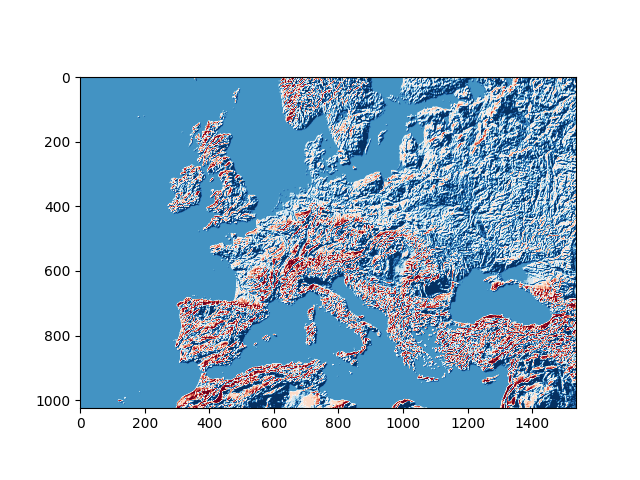

In [14]:

main()
%matplot plt
